# Time Analysis Plot: Visit, Frequency

**Primary Author**

Nuoyi Wang


**Description:**

This notebook contains the basic time analysis of visitation to food-related POI locations and plot the following metrics. 


**Inputs:**

data/weekly_and_core_with_area.csv


**Outputs/Plots of Metrics:**

Overall POI visit counts

Visitor counts by category

Visitor counts by sub category 

Overall visit frequency(visit count/visitor counts)

Visit frequency by category

Visit frequency by sub category 

In [1]:
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
%matplotlib inline

Examples:

https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

https://www.kaggle.com/gaetanlopez/how-to-make-clean-visualizations

https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet <-- last prediction vis style

https://www.kaggle.com/vbmokin/data-science-for-tabular-data-advanced-techniques

https://www.kaggle.com/kanncaa1/time-series-prediction-tutorial-with-eda

You can further study if there needs any statistically processing on the data, like normalization.

Dask is faster to read and process data but dosen't have as much useful APIs as pandas. You can use .compute() to tranform dask dataframe to pandas dataframe. Pandas is slower to read, but ok with other operations. Choose based on your need, good luck!

## weekly_and_core.csv

Joined weekly patterns and core pois' information (in NYC & food related).

In [2]:
weekly_and_core = dd.read_csv("data/weekly_and_core_with_area.csv", dtype={'brands': 'object',
                                                            'distance_from_home': 'float64',
                                                            'opened_on': 'object',
                                                            'parent_placekey': 'object',
                                                            'safegraph_brand_ids': 'object',
                                                            'tracking_opened_since': 'object',
                                                            'category_tags': 'object'}) # dtype to avoid error using dask

In [3]:
len(weekly_and_core.index),len(weekly_and_core.columns) # get the shape when using dask, very slow

(3725207, 37)

In [4]:
weekly_and_core.columns 

Index(['placekey', 'parent_placekey', 'safegraph_brand_ids',
       'date_range_start', 'date_range_end', 'raw_visit_counts',
       'raw_visitor_counts', 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
       'visitor_home_cbgs', 'visitor_daytime_cbgs',
       'visitor_country_of_origin', 'distance_from_home', 'median_dwell',
       'bucketed_dwell_times', 'related_same_day_brand',
       'related_same_week_brand', 'location_name', 'brands', 'top_category',
       'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
       'city', 'region', 'postal_code', 'iso_country_code', 'open_hours',
       'category_tags', 'opened_on', 'closed_on', 'tracking_opened_since',
       'tracking_closed_since', 'category'],
      dtype='object')

In [5]:
weekly_and_core.head(2)

,placekey,parent_placekey,safegraph_brand_ids,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,...,region,postal_code,iso_country_code,open_hours,category_tags,opened_on,closed_on,tracking_opened_since,tracking_closed_since,category
0,222-222@627-s94-nwk,NaN,NaN,2020-12-21T00:00:00-05:00,2020-12-28T00:00:00-05:00,39,24,"[7,9,6,5,3,5,4]","[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...",360470395002,...,NY,11221,US,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,NaN,2019-07,Supermarkets and Specialty Food Stores
1,222-222@627-s94-nwk,NaN,NaN,2021-01-11T00:00:00-05:00,2021-01-18T00:00:00-05:00,41,27,"[3,5,7,4,6,13,3]","[0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...",360470395002,...,NY,11221,US,"{ ""Mon"": [[""8:00"", ""19:00""]], ""Tue"": [[""8:00"",...",NaN,NaN,NaN,NaN,2019-07,Supermarkets and Specialty Food Stores


## Time series exploration

### Weekly visits

In [3]:
weekly_sub = weekly_and_core[['placekey', 'date_range_start', 'raw_visit_counts', 'raw_visitor_counts', 
                 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
                'visitor_home_cbgs', 'visitor_daytime_cbgs', 'distance_from_home', 'median_dwell',
                   'bucketed_dwell_times', 'category']].compute() # compute() tranform dask dataframe to pandas dataframe

In [4]:
weekly_sub.head(2)

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,median_dwell,bucketed_dwell_times,category
0,222-222@627-s94-nwk,2020-12-21T00:00:00-05:00,39,24,"[7,9,6,5,3,5,4]","[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...",360470395002,"{""420950106007"":5,""360470399002"":4,""3604711420...","{""360470411002"":5,""360470385001"":4,""3604703950...",1911.0,49.0,"{""<5"":0,""5-10"":4,""11-20"":12,""21-60"":6,""61-120""...",Supermarkets and Specialty Food Stores
1,222-222@627-s94-nwk,2021-01-11T00:00:00-05:00,41,27,"[3,5,7,4,6,13,3]","[0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...",360470395002,"{""360470397003"":8,""360810142011"":4,""3604703950...","{""360470395002"":4,""360810008002"":4,""3608110290...",5109.0,34.0,"{""<5"":0,""5-10"":7,""11-20"":9,""21-60"":9,""61-120"":...",Supermarkets and Specialty Food Stores


In [8]:
len(weekly_sub['placekey'].unique())

36467

In [9]:
# re-coded 6 categories
weekly_sub['category'].unique()

array(['Supermarkets and Specialty Food Stores',
       'Restaurants and Other Eating Places',
       'General Merchandise and Convenience Stores',
       'Community and Special Food Services',
       'Food (Health) Supplement Stores', 'Tobacco and Liquor Stores'],
      dtype=object)

In [10]:
# utc=True, or won't return datetime64 and can't use .dt
weekly_sub['date_range_start'] = pd.to_datetime(weekly_sub['date_range_start'], infer_datetime_format=True, utc=True)
weekly_sub['date'] = weekly_sub['date_range_start'].dt.date
weekly_sub['date'].head()

0    2020-12-21
1    2021-01-11
2    2021-01-18
3    2021-01-25
4    2019-01-07
Name: date, dtype: object

In [11]:
min(weekly_sub['date']), max(weekly_sub['date'])

(datetime.date(2018, 12, 31), datetime.date(2021, 2, 15))

In [12]:
weekly_sum = weekly_sub.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean'
                                           }) 
weekly_sum.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell
date,,,,
2018-12-31,4593861,1914598,11728.628460,51.870476
2019-01-07,4217047,2029110,7923.424194,48.499096
2019-01-14,2772868,2054751,8551.591970,49.262725
2019-01-21,2598610,1956701,7863.916092,49.342290
2019-01-28,2726099,2045011,6617.508883,50.606984


In [13]:
# set the figure and font size
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":25, "axes.labelsize":15})

In [14]:
'2020-03-17' in weekly_sum.index

False

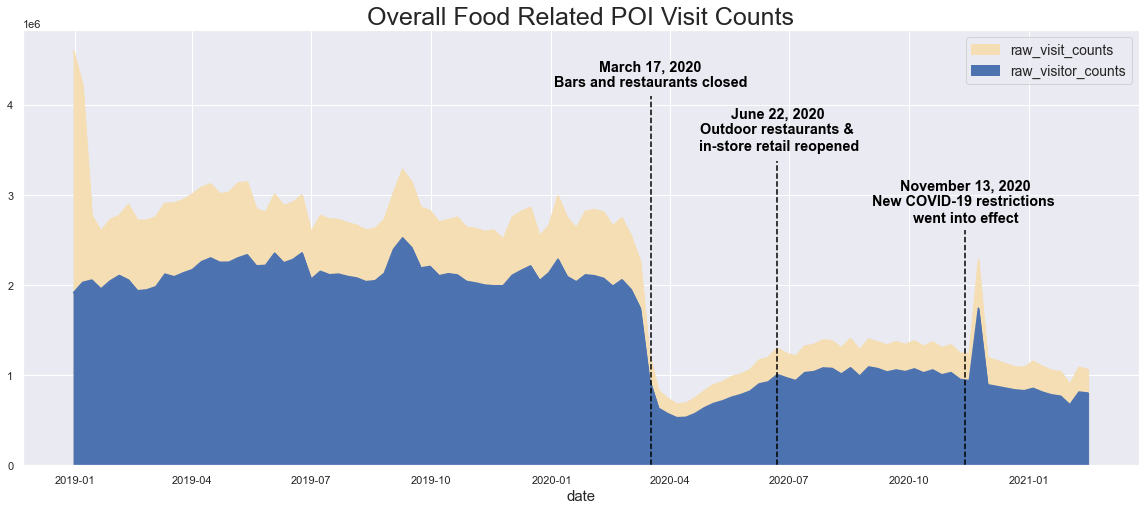

In [15]:
plt.figure(figsize=(20,8))
weekly_sum['raw_visit_counts'].plot(kind='area', color='wheat')
weekly_sum['raw_visitor_counts'].plot(kind='area')

plt.axvline('2020-03-17', 0,0.85, color='black', linestyle='dashed')
plt.text('2020-03-17', 4.2e6, "March 17, 2020\nBars and restaurants closed", 
         horizontalalignment='center', size='large', color='black', weight='semibold')

plt.axvline('2020-06-22', 0,0.70, color='black', linestyle='dashed')
plt.text('2020-06-22', 3.5e6, "June 22, 2020\nOutdoor restaurants &\n in-store retail reopened", 
         horizontalalignment='center', size='large', color='black', weight='semibold')


plt.axvline('2020-11-13', 0,0.54, color='black', linestyle='dashed')
plt.text('2020-11-13', 2.7e6, "November 13, 2020\nNew COVID-19 restrictions \nwent into effect", 
         horizontalalignment='center', size='large', color='black', weight='semibold')

plt.legend(fontsize='14')
plt.title("Overall Food Related POI Visit Counts")
plt.show()

In [16]:
weekly_sum[(weekly_sum.index>pd.to_datetime('2020-11-01'))&(weekly_sum.index<pd.to_datetime('2020-12-01'))]['raw_visitor_counts']

date
2020-11-02    1028715
2020-11-09     953031
2020-11-16     939669
2020-11-23    1742994
2020-11-30     893813
Name: raw_visitor_counts, dtype: int64

In [17]:
weekly_category = weekly_sub.groupby(['category', 'date'], as_index=False).agg({'raw_visit_counts':'sum', 
                                                                    'raw_visitor_counts':'sum', 
                                                                  'distance_from_home':'mean', 
                                                                    'median_dwell':'mean'
                                                                   })
weekly_category.head()

,category,date,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell
0,Community and Special Food Services,2018-12-31,35360,14234,14271.188755,78.823420
1,Community and Special Food Services,2019-01-07,32575,15109,13680.460630,66.322222
2,Community and Special Food Services,2019-01-14,21321,15077,9415.944664,70.919776
3,Community and Special Food Services,2019-01-21,19993,14472,8452.273092,70.785448
4,Community and Special Food Services,2019-01-28,20873,15043,8298.085020,74.675373


<AxesSubplot:xlabel='date', ylabel='raw_visitor_counts'>

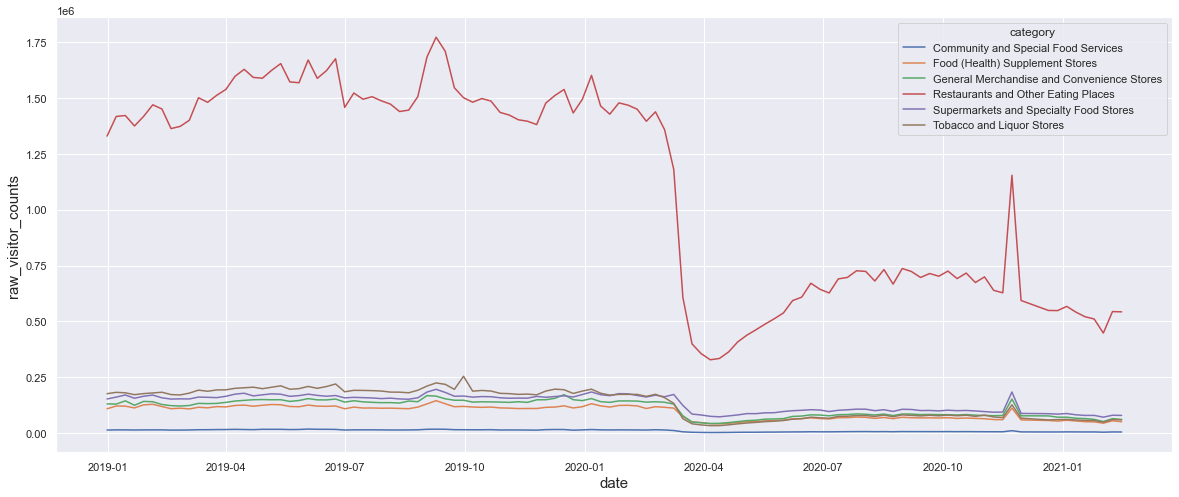

In [18]:
sns.lineplot(data= weekly_category, x="date", y="raw_visitor_counts", hue="category")

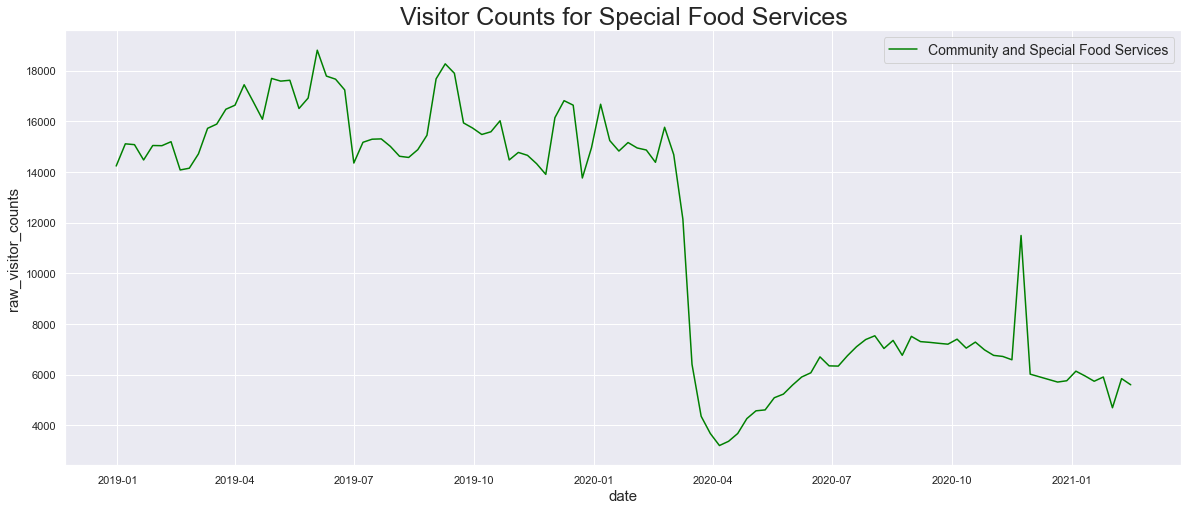

In [19]:
sns.lineplot(data= weekly_category[weekly_category.category=='Community and Special Food Services'], 
             x="date", y="raw_visitor_counts", hue="category", palette=['green']).set(title="Visitor Counts for Special Food Services")
plt.legend(fontsize='14')
plt.show()

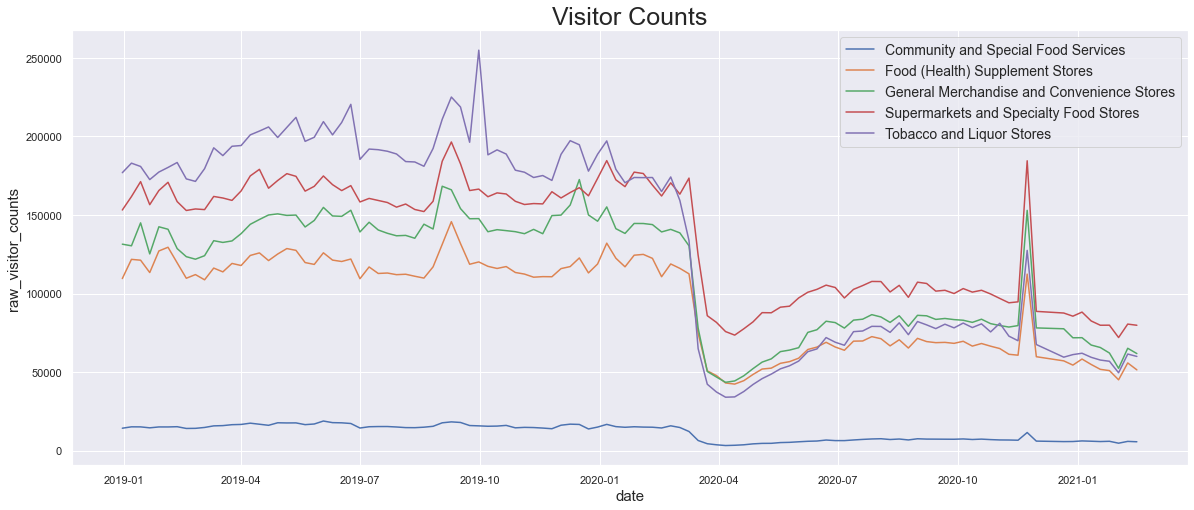

In [20]:
four_cat = ['Supermarkets and Specialty Food Stores',
       'General Merchandise and Convenience Stores',
       'Food (Health) Supplement Stores',
       'Tobacco and Liquor Stores',
           'Community and Special Food Services',]
sns.lineplot(data= weekly_category[weekly_category.category.isin(four_cat)], 
             x="date", y="raw_visitor_counts", hue="category").set(title="Visitor Counts")
plt.legend(fontsize='14')
plt.show()

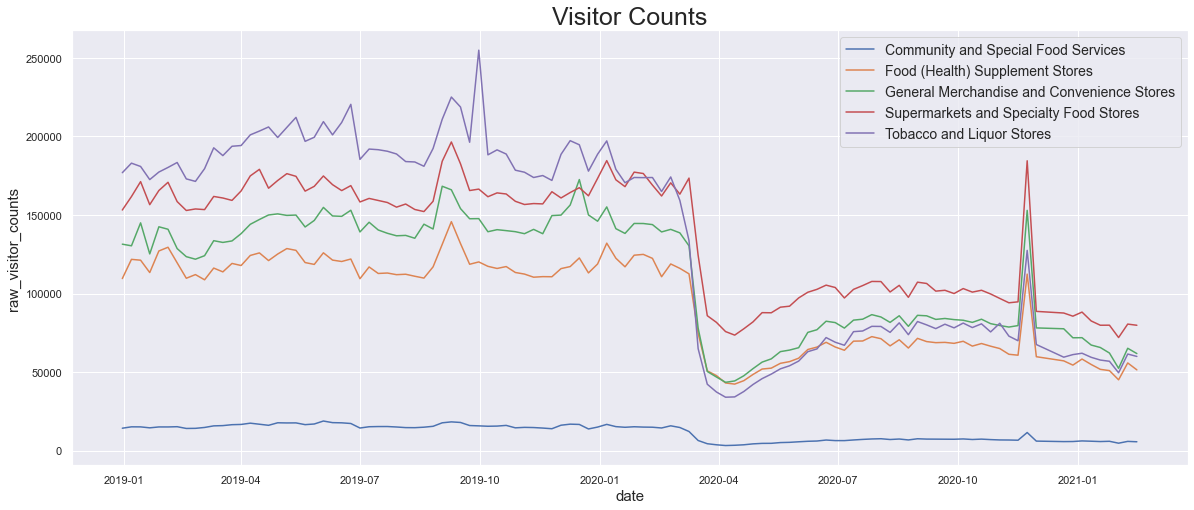

In [21]:
#add tobacco line
four_cat = ['Supermarkets and Specialty Food Stores',
       'General Merchandise and Convenience Stores',
       'Food (Health) Supplement Stores',
       'Tobacco and Liquor Stores',
       'Community and Special Food Services']
sns.lineplot(data= weekly_category[weekly_category.category.isin(four_cat)], 
             x="date", y="raw_visitor_counts", hue="category").set(title="Visitor Counts")
plt.legend(fontsize='14')
plt.show()

### POI Category Information

top category, sub category

In [16]:
weekly_ctg = weekly_and_core[['placekey', 'date_range_start', 'raw_visit_counts', 'raw_visitor_counts', 
                 'visits_by_day', 'visits_by_each_hour', 'poi_cbg',
                'visitor_home_cbgs', 'visitor_daytime_cbgs', 'distance_from_home', 'median_dwell',
                   'bucketed_dwell_times','top_category','sub_category' ,'category']].compute() # compute() tranform dask dataframe to pandas dataframe

In [17]:
weekly_ctg['category'].unique()

array(['Supermarkets and Specialty Food Stores',
       'Restaurants and Other Eating Places',
       'General Merchandise and Convenience Stores',
       'Community and Special Food Services',
       'Food (Health) Supplement Stores', 'Tobacco and Liquor Stores'],
      dtype=object)

In [19]:
weekly_ctg[['category','top_category','sub_category']].values

array([['Supermarkets and Specialty Food Stores',
        'Specialty Food Stores', 'Meat Markets'],
       ['Supermarkets and Specialty Food Stores',
        'Specialty Food Stores', 'Meat Markets'],
       ['Supermarkets and Specialty Food Stores',
        'Specialty Food Stores', 'Meat Markets'],
       ...,
       ['Tobacco and Liquor Stores',
        'Drinking Places (Alcoholic Beverages)',
        'Drinking Places (Alcoholic Beverages)'],
       ['Tobacco and Liquor Stores',
        'Drinking Places (Alcoholic Beverages)',
        'Drinking Places (Alcoholic Beverages)'],
       ['Tobacco and Liquor Stores',
        'Drinking Places (Alcoholic Beverages)',
        'Drinking Places (Alcoholic Beverages)']], dtype=object)

In [22]:
category_group=weekly_ctg[['category','top_category','sub_category']].groupby('category')
category_group.head()

,category,top_category,sub_category
0,Supermarkets and Specialty Food Stores,Specialty Food Stores,Meat Markets
1,Supermarkets and Specialty Food Stores,Specialty Food Stores,Meat Markets
2,Supermarkets and Specialty Food Stores,Specialty Food Stores,Meat Markets
3,Supermarkets and Specialty Food Stores,Specialty Food Stores,Meat Markets
4,Supermarkets and Specialty Food Stores,Specialty Food Stores,Meat Markets
25708,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Full-Service Restaurants
25709,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Full-Service Restaurants
25710,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Full-Service Restaurants
25711,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Full-Service Restaurants
25712,Restaurants and Other Eating Places,Restaurants and Other Eating Places,Full-Service Restaurants


In [23]:
weekly_ctg['date_range_start'] = pd.to_datetime(weekly_ctg['date_range_start'], infer_datetime_format=True, utc=True)
weekly_ctg['date'] = weekly_ctg['date_range_start'].dt.date
weekly_ctg['date'].head()

0    2020-12-21
1    2021-01-11
2    2021-01-18
3    2021-01-25
4    2019-01-07
Name: date, dtype: object

In [ ]:
weekly_sum = weekly_sub.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean'
                                           }) 
weekly_sum.head()

In [25]:
weekly_ctg = weekly_ctg.groupby(['sub_category','category', 'date'], as_index=False).agg({'raw_visit_counts':'sum', 
                                                                    'raw_visitor_counts':'sum', 
                                                                  'distance_from_home':'mean', 
                                                                    'median_dwell':'mean'
                                                                   })
weekly_ctg.head()

,sub_category,category,date,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell
0,All Other General Merchandise Stores,General Merchandise and Convenience Stores,2018-12-31,109389,47630,5692.278723,32.190476
1,All Other General Merchandise Stores,General Merchandise and Convenience Stores,2019-01-07,100848,51402,4002.434322,33.647727
2,All Other General Merchandise Stores,General Merchandise and Convenience Stores,2019-01-14,66829,52061,3919.617336,33.062757
3,All Other General Merchandise Stores,General Merchandise and Convenience Stores,2019-01-21,62550,49320,4206.050420,31.645661
4,All Other General Merchandise Stores,General Merchandise and Convenience Stores,2019-01-28,64151,50624,3729.054622,32.462887


In [36]:
weekly_ctg[weekly_ctg.category=='Community and Special Food Services']

,sub_category,category,date,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell
550,Caterers,Community and Special Food Services,2018-12-31,35359,14233,14271.188755,76.382463
551,Caterers,Community and Special Food Services,2019-01-07,32575,15109,13680.460630,66.322222
552,Caterers,Community and Special Food Services,2019-01-14,21321,15077,9415.944664,70.919776
553,Caterers,Community and Special Food Services,2019-01-21,19993,14472,8452.273092,70.785448
554,Caterers,Community and Special Food Services,2019-01-28,20873,15043,8298.085020,74.675373
...,...,...,...,...,...,...,...
674,Community Food Services,Community and Special Food Services,2020-03-30,1,1,NaN,530.000000
675,Community Food Services,Community and Special Food Services,2020-06-22,2,2,NaN,806.000000
676,Community Food Services,Community and Special Food Services,2020-07-20,1,1,NaN,631.000000
677,Community Food Services,Community and Special Food Services,2020-08-03,1,1,NaN,885.000000


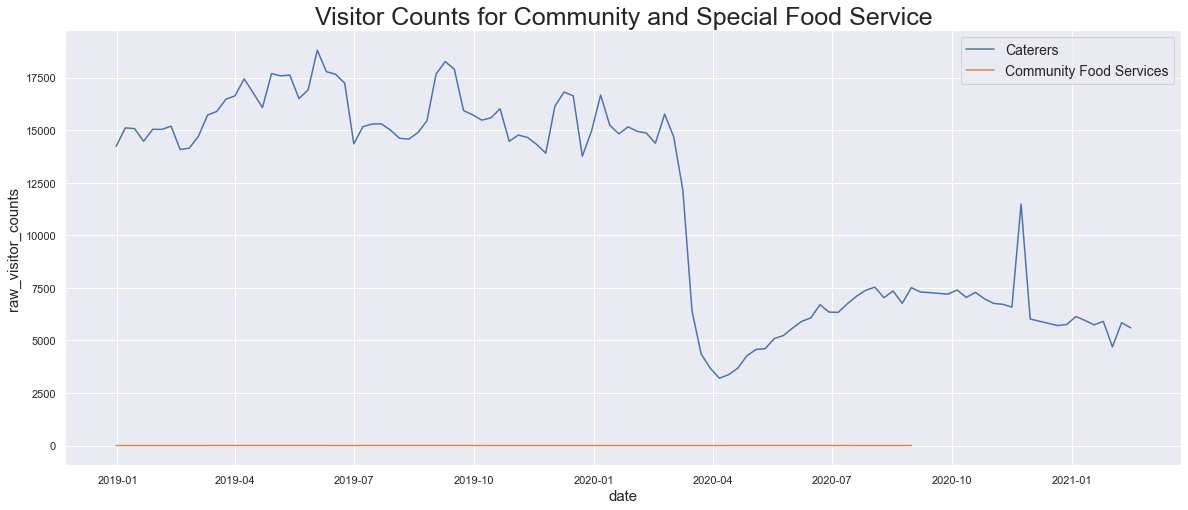

In [35]:
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":25, "axes.labelsize":15})
sns.lineplot(data= weekly_ctg[weekly_ctg.category=='Community and Special Food Services'], 
             x="date", y="raw_visitor_counts", hue="sub_category").set(title="Visitor Counts for Community and Special Food Service")
plt.legend(fontsize='14')
plt.show()

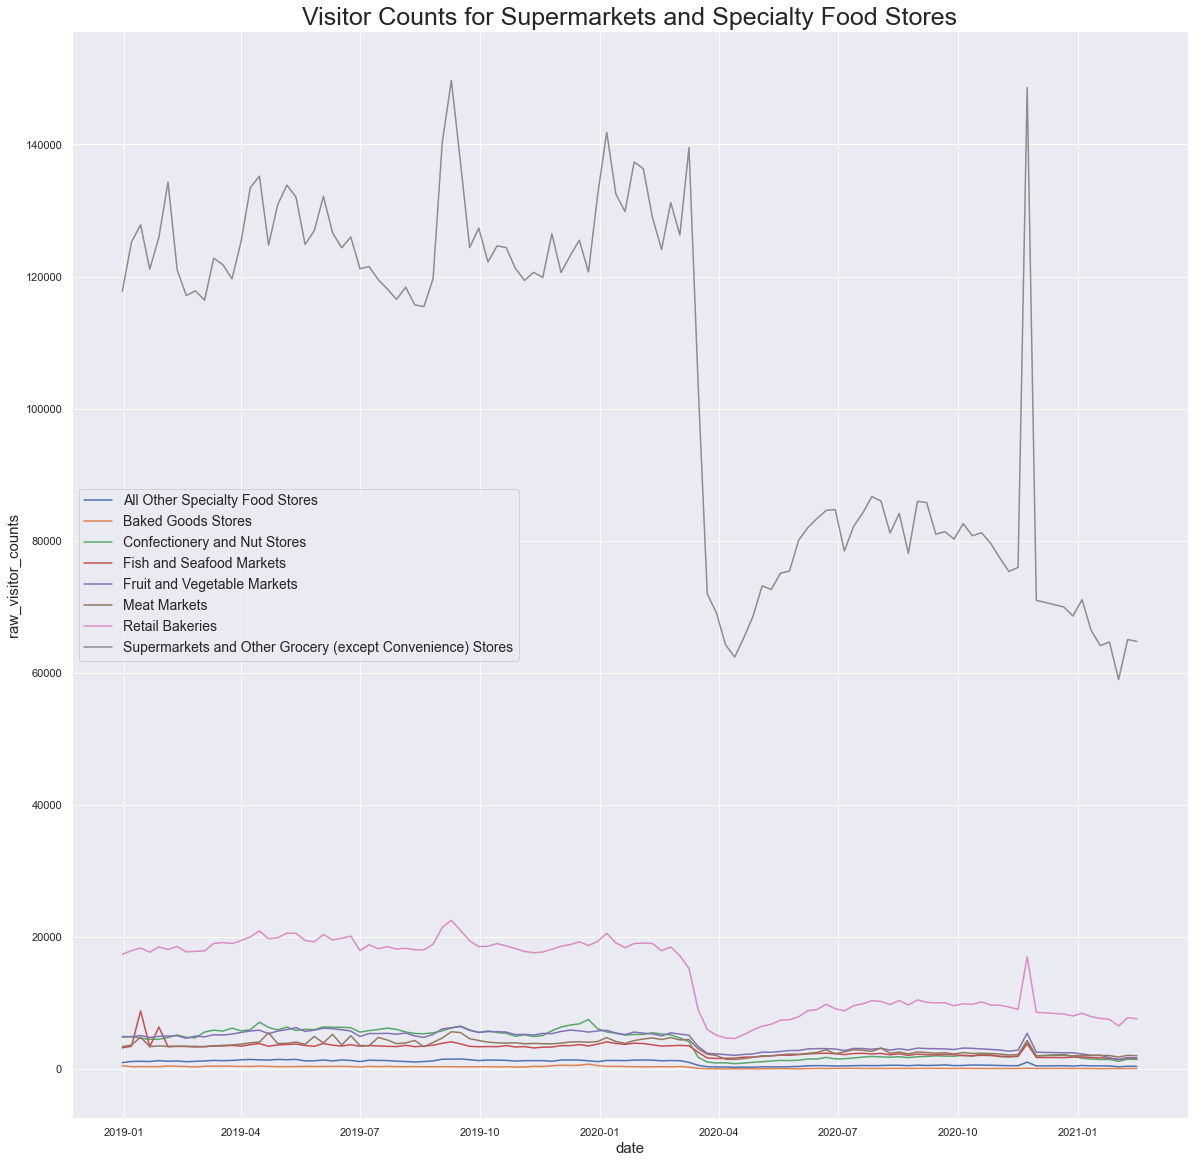

In [41]:
sns.set(rc={'figure.figsize':(20, 20), "axes.titlesize":25, "axes.labelsize":15})
sns.lineplot(data= weekly_ctg[weekly_ctg.category=='Supermarkets and Specialty Food Stores'], 
             x="date", y="raw_visitor_counts", hue="sub_category").set(title="Visitor Counts for Supermarkets and Specialty Food Stores")
plt.legend(fontsize='14')
plt.show()

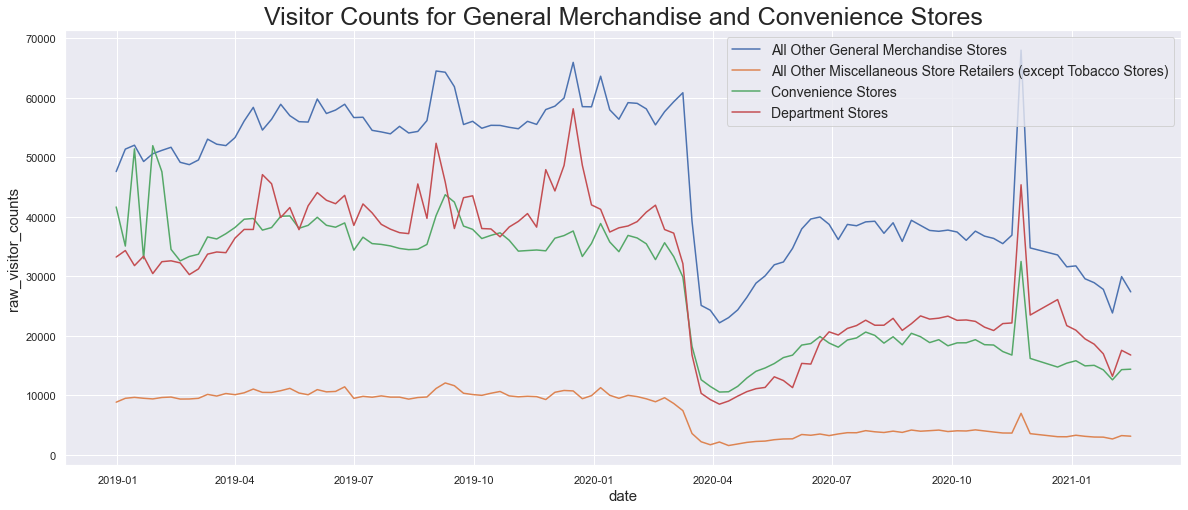

In [38]:
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":25, "axes.labelsize":15})
sns.lineplot(data= weekly_ctg[weekly_ctg.category=='General Merchandise and Convenience Stores'], 
             x="date", y="raw_visitor_counts", hue="sub_category").set(title="Visitor Counts for General Merchandise and Convenience Stores")
plt.legend(fontsize='14')
plt.show()

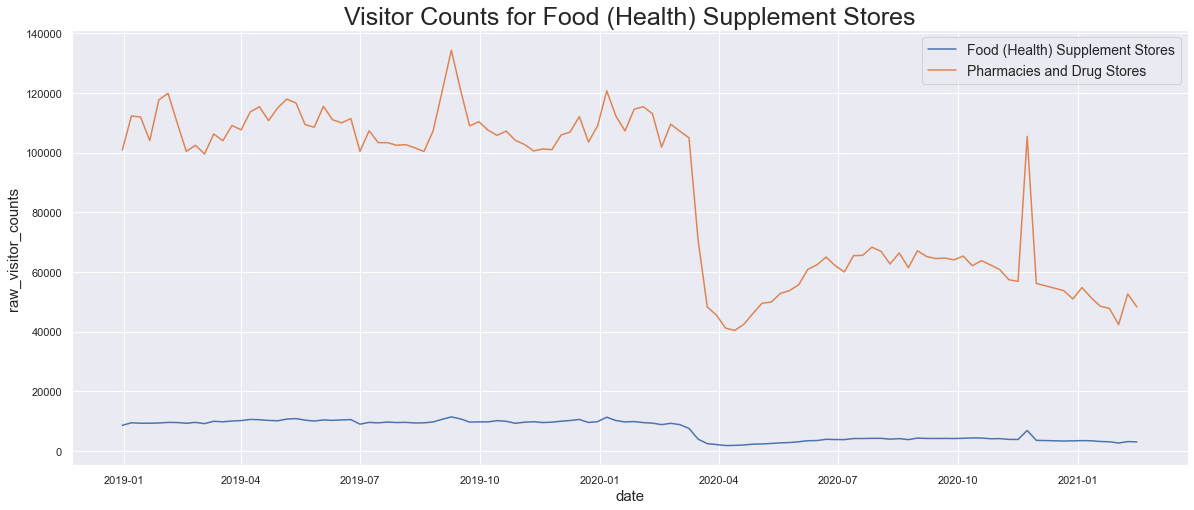

In [39]:
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":25, "axes.labelsize":15})
sns.lineplot(data= weekly_ctg[weekly_ctg.category=='Food (Health) Supplement Stores'], 
             x="date", y="raw_visitor_counts", hue="sub_category").set(title="Visitor Counts for Food (Health) Supplement Stores")
plt.legend(fontsize='14')
plt.show()

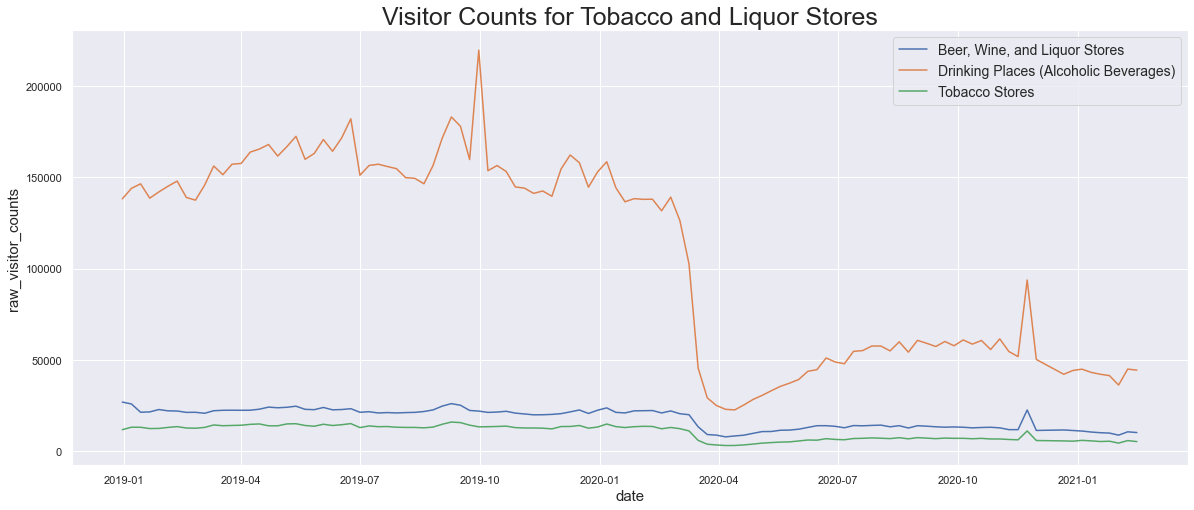

In [40]:
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":25, "axes.labelsize":15})
sns.lineplot(data= weekly_ctg[weekly_ctg.category=='Tobacco and Liquor Stores'], 
             x="date", y="raw_visitor_counts", hue="sub_category").set(title="Visitor Counts for Tobacco and Liquor Stores")
plt.legend(fontsize='14')
plt.show()

## Frequency

In [22]:
weekly_fre=weekly_sum
weekly_fre['frequency']=weekly_fre['raw_visit_counts']/weekly_fre['raw_visitor_counts']
weekly_fre.head(2)

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,frequency
date,,,,,
2018-12-31,4593861,1914598,11728.628460,51.870476,2.399387
2019-01-07,4217047,2029110,7923.424194,48.499096,2.078274


In [23]:
# set the figure and font size
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":25, "axes.labelsize":15})

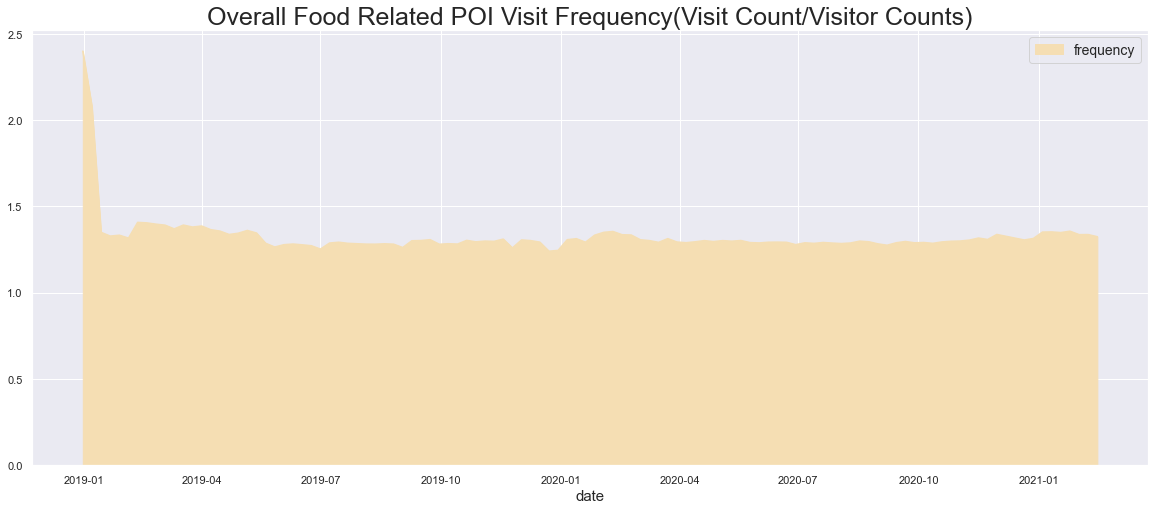

In [24]:

plt.figure(figsize=(20,8))
weekly_fre['frequency'].plot(kind='area', color='wheat')

plt.legend(fontsize='14')
plt.title("Overall Food Related POI Visit Frequency(Visit Count/Visitor Counts)")
plt.show()

In [25]:
weekly_fre[(weekly_fre.index>pd.to_datetime('2020-11-01'))&(weekly_fre.index<pd.to_datetime('2020-12-01'))]['frequency']

date
2020-11-02    1.299430
2020-11-09    1.304695
2020-11-16    1.316684
2020-11-23    1.308166
2020-11-30    1.337478
Name: frequency, dtype: float64

In [26]:
weekly_sum = weekly_sub.groupby('date').agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum', 
                                          'distance_from_home':'mean', 'median_dwell':'mean'
                                           }) 
weekly_sum.head()

,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell
date,,,,
2018-12-31,4593861,1914598,11728.628460,51.870476
2019-01-07,4217047,2029110,7923.424194,48.499096
2019-01-14,2772868,2054751,8551.591970,49.262725
2019-01-21,2598610,1956701,7863.916092,49.342290
2019-01-28,2726099,2045011,6617.508883,50.606984


In [27]:
weekly_sub.head()

,placekey,date_range_start,raw_visit_counts,raw_visitor_counts,visits_by_day,visits_by_each_hour,poi_cbg,visitor_home_cbgs,visitor_daytime_cbgs,distance_from_home,median_dwell,bucketed_dwell_times,category,date
0,222-222@627-s94-nwk,2020-12-21 05:00:00+00:00,39,24,"[7,9,6,5,3,5,4]","[0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0...",360470395002,"{""420950106007"":5,""360470399002"":4,""3604711420...","{""360470411002"":5,""360470385001"":4,""3604703950...",1911.0,49.0,"{""<5"":0,""5-10"":4,""11-20"":12,""21-60"":6,""61-120""...",Supermarkets and Specialty Food Stores,2020-12-21
1,222-222@627-s94-nwk,2021-01-11 05:00:00+00:00,41,27,"[3,5,7,4,6,13,3]","[0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0...",360470395002,"{""360470397003"":8,""360810142011"":4,""3604703950...","{""360470395002"":4,""360810008002"":4,""3608110290...",5109.0,34.0,"{""<5"":0,""5-10"":7,""11-20"":9,""21-60"":9,""61-120"":...",Supermarkets and Specialty Food Stores,2021-01-11
2,222-222@627-s94-nwk,2021-01-18 05:00:00+00:00,39,21,"[3,6,7,6,7,8,2]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1...",360470395002,"{""360470377002"":4,""360470251001"":4,""3604703710...","{""360470363002"":4,""360470573001"":4,""5165001140...",4406.0,22.0,"{""<5"":0,""5-10"":4,""11-20"":15,""21-60"":5,""61-120""...",Supermarkets and Specialty Food Stores,2021-01-18
3,222-222@627-s94-nwk,2021-01-25 05:00:00+00:00,45,24,"[6,5,7,8,5,6,8]","[0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,1,0,1,0,0,0...",360470395002,"{""360470226002"":5,""360470437002"":4,""3604703650...","{""360470395002"":4,""360850138002"":4,""3604704370...",5607.0,26.0,"{""<5"":0,""5-10"":5,""11-20"":11,""21-60"":11,""61-120...",Supermarkets and Specialty Food Stores,2021-01-25
4,222-222@627-s94-nwk,2019-01-07 05:00:00+00:00,75,40,"[4,6,14,24,8,10,9]","[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0...",360470395002,"{""360470293002"":5,""360470395002"":4,""3604704170...","{""360470369004"":4,""360470924001"":4,""3604708020...",2171.0,18.0,"{""<5"":2,""5-10"":20,""11-20"":20,""21-60"":17,""61-12...",Supermarkets and Specialty Food Stores,2019-01-07


In [28]:
weekly_fre_ctg=weekly_sub
#weekly_fre_ctg['frequency']=weekly_fre_ctg['raw_visit_counts']/weekly_fre_ctg['raw_visitor_counts']
weekly_fre_ctg =  weekly_fre_ctg.groupby(['date','category'], as_index=False).agg({'raw_visit_counts':'sum', 'raw_visitor_counts':'sum' 
                                           }) 

weekly_fre_ctg.head()

,date,category,raw_visit_counts,raw_visitor_counts
0,2018-12-31,Community and Special Food Services,35360,14234
1,2018-12-31,Food (Health) Supplement Stores,257240,109522
2,2018-12-31,General Merchandise and Convenience Stores,312232,131427
3,2018-12-31,Restaurants and Other Eating Places,3185230,1329310
4,2018-12-31,Supermarkets and Specialty Food Stores,376367,153172


In [29]:
weekly_fre_ctg['frequency']=weekly_fre_ctg['raw_visit_counts']/weekly_fre_ctg['raw_visitor_counts']
weekly_fre_ctg.head(2)

,date,category,raw_visit_counts,raw_visitor_counts,frequency
0,2018-12-31,Community and Special Food Services,35360,14234,2.484193
1,2018-12-31,Food (Health) Supplement Stores,257240,109522,2.348752


Text(0.5, 1.0, 'Food Related POI Visit Frequency(by POI category)')

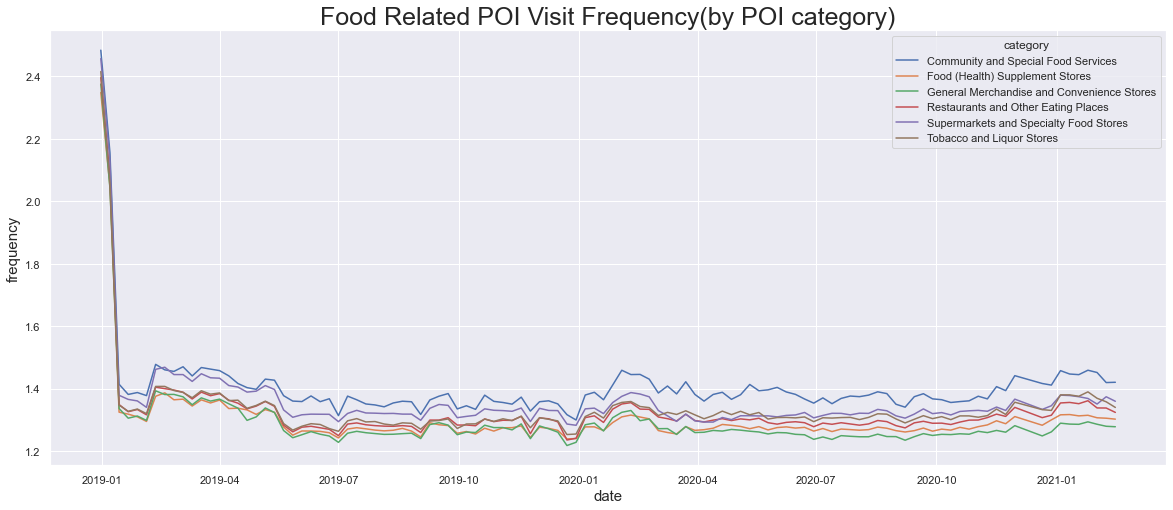

In [30]:
sns.lineplot(data= weekly_fre_ctg, x="date", y="frequency", hue="category")
plt.title("Food Related POI Visit Frequency(by POI category)")

Text(0.5, 1.0, 'Food Related POI Visit Frequency(by POI category)')

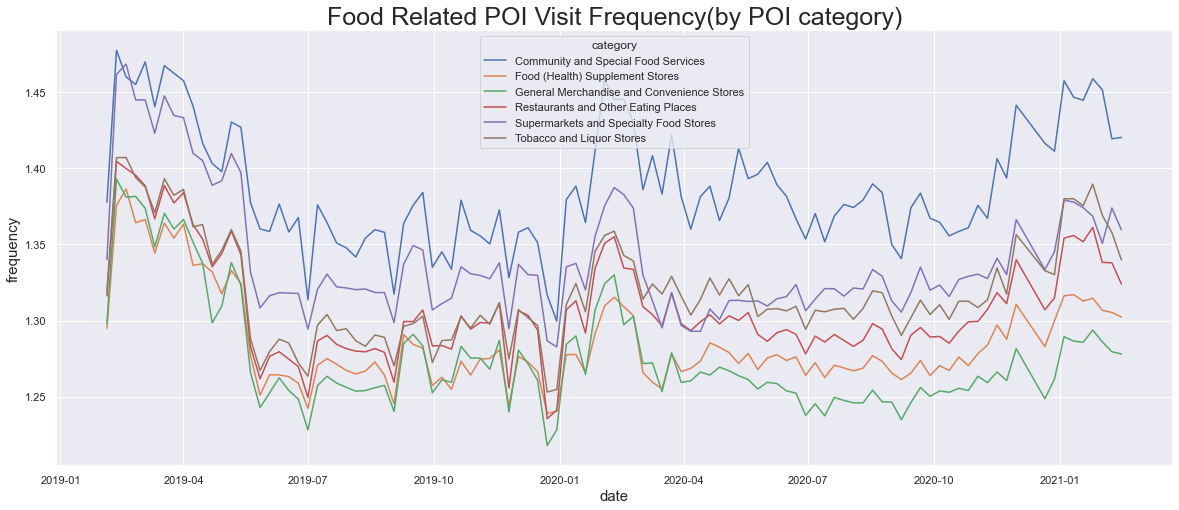

In [31]:
#drop the start of line
sns.lineplot(data= weekly_fre_ctg[weekly_fre_ctg['date']>pd.to_datetime('2019-02')], x="date", y="frequency", hue="category")
plt.title("Food Related POI Visit Frequency(by POI category)")

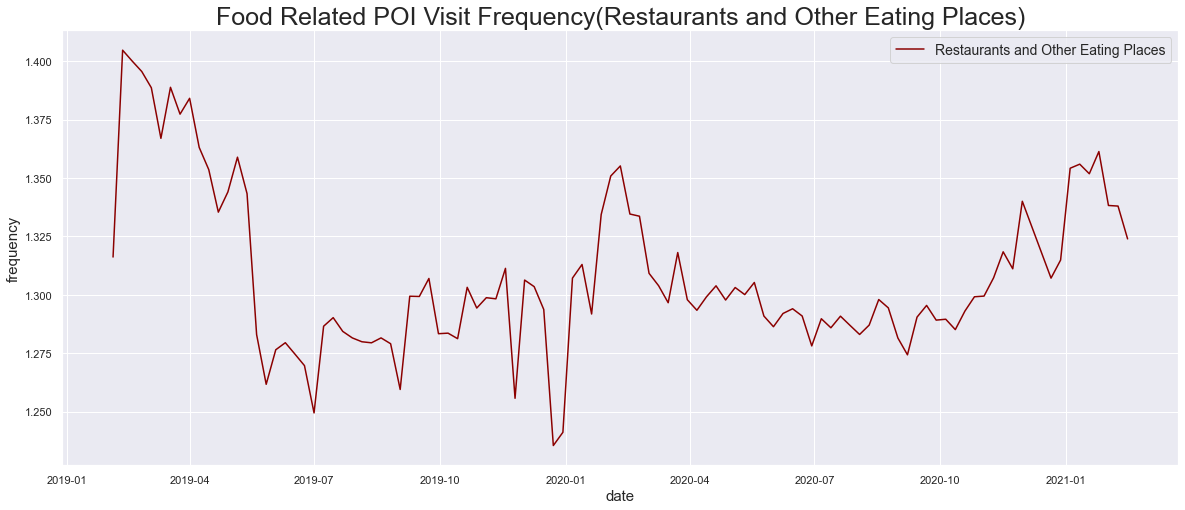

In [32]:
weekly_fre_ctg=weekly_fre_ctg[weekly_fre_ctg['date']>pd.to_datetime('2019-02')]
sns.lineplot(data= weekly_fre_ctg[weekly_fre_ctg.category=='Restaurants and Other Eating Places'],
             x="date", y="frequency", hue="category", palette=['darkred']).set(title="Food Related POI Visit Frequency(Restaurants and Other Eating Places)")
plt.legend(fontsize='14')
plt.show()

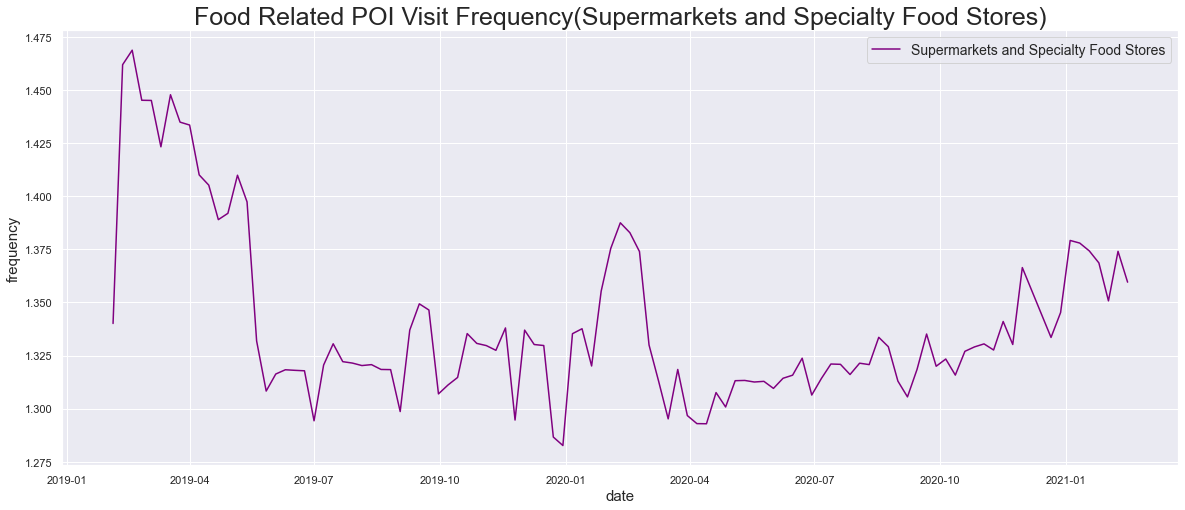

In [33]:
weekly_fre_ctg=weekly_fre_ctg[weekly_fre_ctg['date']>pd.to_datetime('2019-02')]
sns.lineplot(data= weekly_fre_ctg[weekly_fre_ctg.category=='Supermarkets and Specialty Food Stores'],
             x="date", y="frequency", hue="category", palette=['purple']).set(title="Food Related POI Visit Frequency(Supermarkets and Specialty Food Stores)")
plt.legend(fontsize='14')
plt.show()

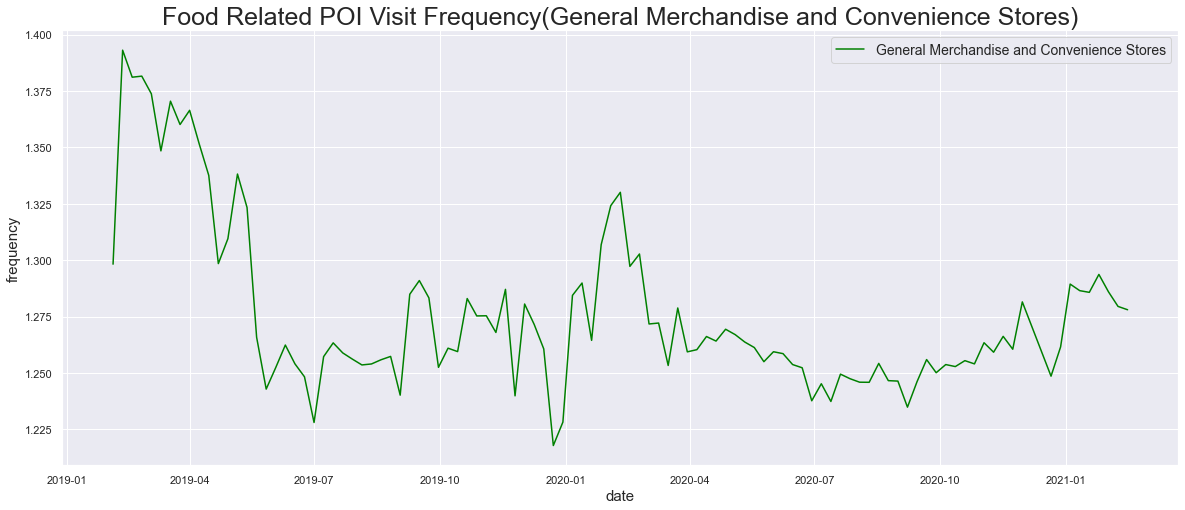

In [34]:
weekly_fre_ctg=weekly_fre_ctg[weekly_fre_ctg['date']>pd.to_datetime('2019-02')]
sns.lineplot(data= weekly_fre_ctg[weekly_fre_ctg.category=='General Merchandise and Convenience Stores'],
             x="date", y="frequency", hue="category", palette=['green']).set(title="Food Related POI Visit Frequency(General Merchandise and Convenience Stores)")
plt.legend(fontsize='14')
plt.show()

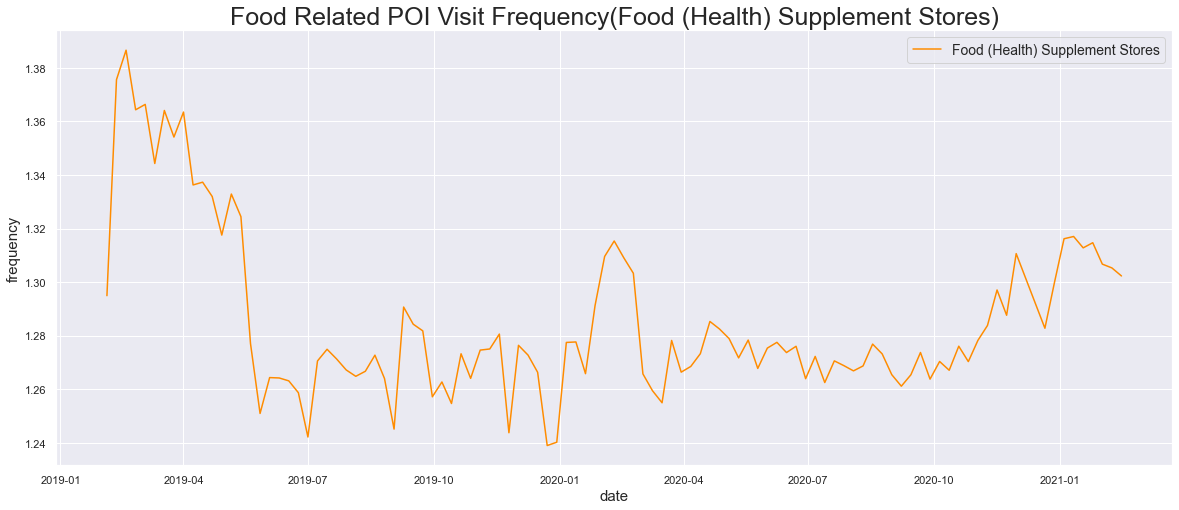

In [35]:
weekly_fre_ctg=weekly_fre_ctg[weekly_fre_ctg['date']>pd.to_datetime('2019-02')]
sns.lineplot(data= weekly_fre_ctg[weekly_fre_ctg.category=='Food (Health) Supplement Stores'],
             x="date", y="frequency", hue="category", palette=['darkorange']).set(title="Food Related POI Visit Frequency(Food (Health) Supplement Stores)")
plt.legend(fontsize='14')
plt.show()

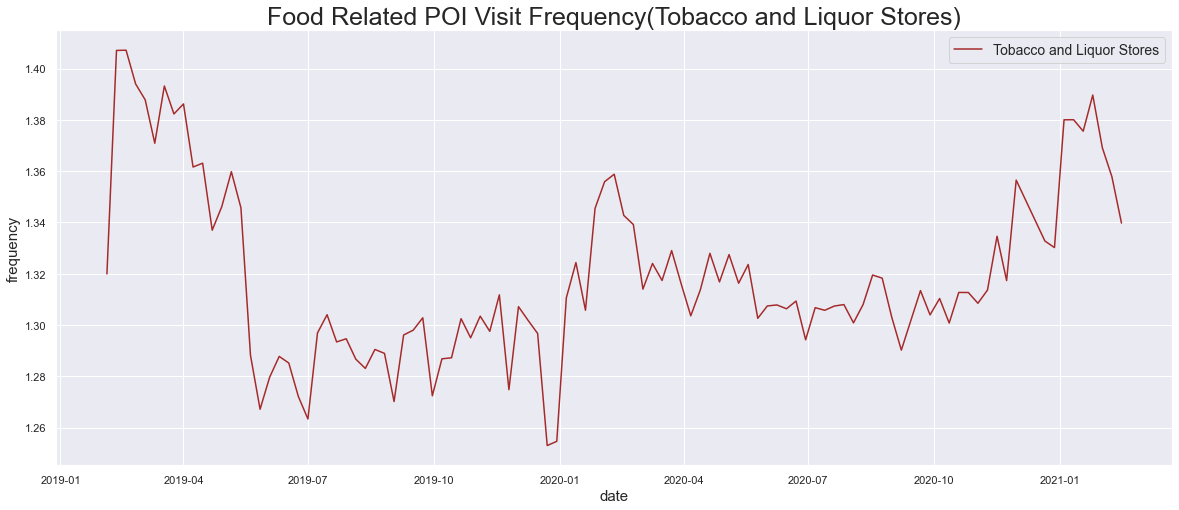

In [36]:
weekly_fre_ctg=weekly_fre_ctg[weekly_fre_ctg['date']>pd.to_datetime('2019-02')]
sns.lineplot(data= weekly_fre_ctg[weekly_fre_ctg.category=='Tobacco and Liquor Stores'],
             x="date", y="frequency", hue="category", palette=['brown']).set(title="Food Related POI Visit Frequency(Tobacco and Liquor Stores)")
plt.legend(fontsize='14')
plt.show()

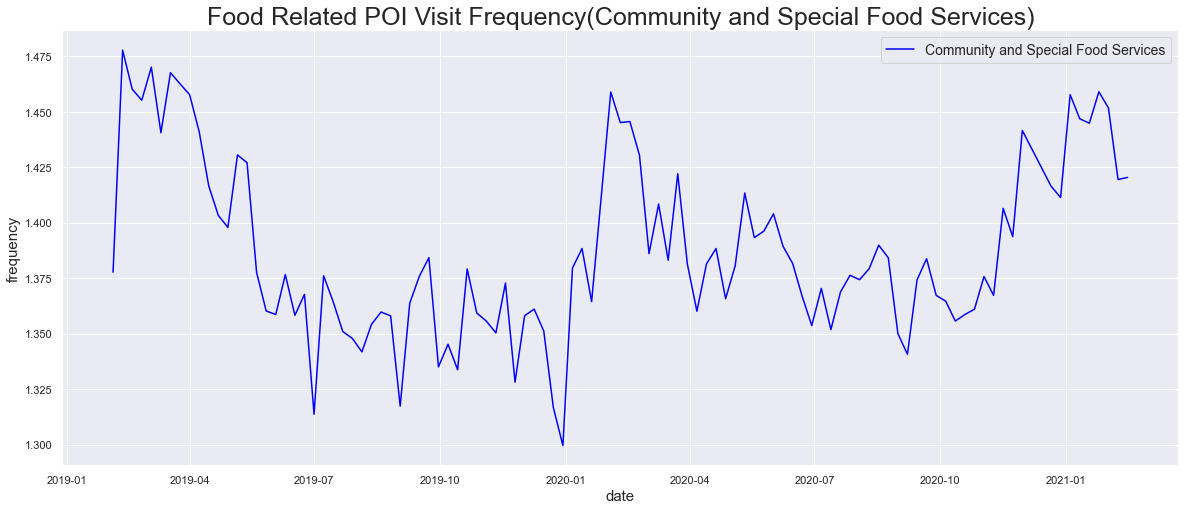

In [37]:
weekly_fre_ctg=weekly_fre_ctg[weekly_fre_ctg['date']>pd.to_datetime('2019-02')]
sns.lineplot(data= weekly_fre_ctg[weekly_fre_ctg.category=='Community and Special Food Services'],
             x="date", y="frequency", hue="category", palette=['blue']).set(title="Food Related POI Visit Frequency(Community and Special Food Services)")
plt.legend(fontsize='14')
plt.show()

frequency_POI category information

In [43]:
weekly_freq_ctg=weekly_ctg
weekly_freq_ctg['frequency']=weekly_freq_ctg['raw_visit_counts']/weekly_freq_ctg['raw_visitor_counts']
weekly_freq_ctg.head(2)

,sub_category,category,date,raw_visit_counts,raw_visitor_counts,distance_from_home,median_dwell,frequency
0,All Other General Merchandise Stores,General Merchandise and Convenience Stores,2018-12-31,109389,47630,5692.278723,32.190476,2.296641
1,All Other General Merchandise Stores,General Merchandise and Convenience Stores,2019-01-07,100848,51402,4002.434322,33.647727,1.961947


In [44]:
# set the figure and font size
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":25, "axes.labelsize":15})

Text(0.5, 1.0, 'Food Related POI Visit Frequency(by POI category)')

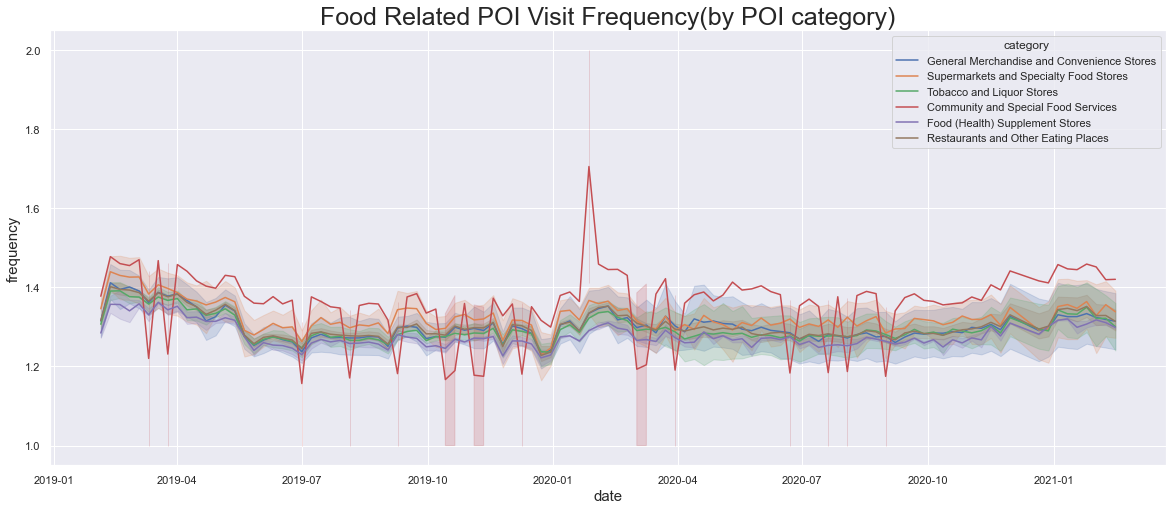

In [46]:
#drop the start of line
sns.lineplot(data= weekly_freq_ctg[weekly_freq_ctg['date']>pd.to_datetime('2019-02')], x="date", y="frequency", hue="category")
plt.title("Food Related POI Visit Frequency(by POI category)")

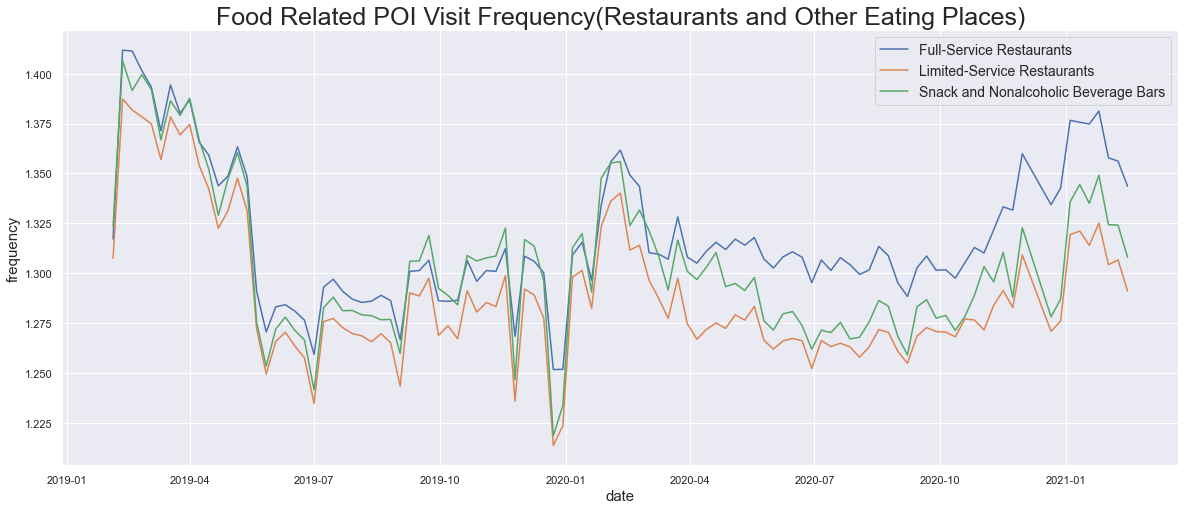

In [48]:
weekly_freq_ctg=weekly_freq_ctg[weekly_freq_ctg['date']>pd.to_datetime('2019-02')]
sns.lineplot(data= weekly_freq_ctg[weekly_freq_ctg.category=='Restaurants and Other Eating Places'],
             x="date", y="frequency", hue="sub_category").set(title="Food Related POI Visit Frequency(Restaurants and Other Eating Places)")
plt.legend(fontsize='14')
plt.show()

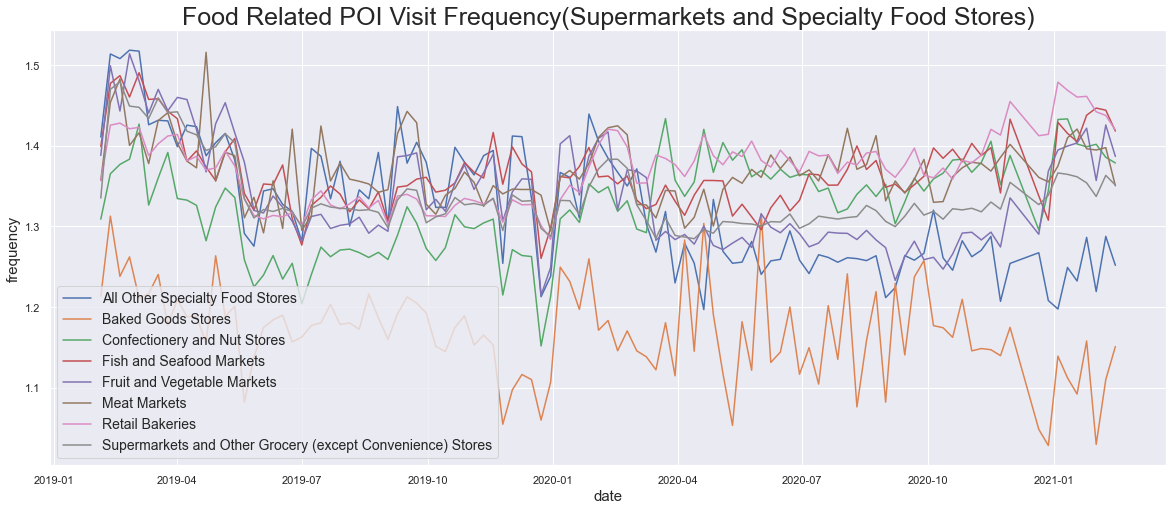

In [49]:
sns.lineplot(data= weekly_freq_ctg[weekly_freq_ctg.category=='Supermarkets and Specialty Food Stores'],
             x="date", y="frequency", hue="sub_category").set(title="Food Related POI Visit Frequency(Supermarkets and Specialty Food Stores)")
plt.legend(fontsize='14')
plt.show()

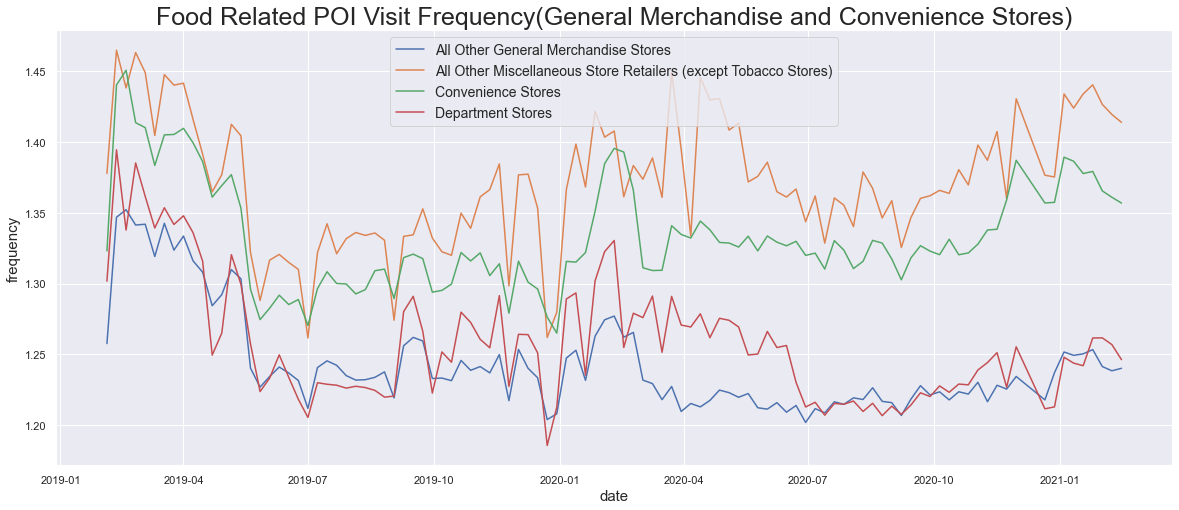

In [50]:
sns.lineplot(data= weekly_freq_ctg[weekly_freq_ctg.category=='General Merchandise and Convenience Stores'],
             x="date", y="frequency", hue="sub_category").set(title="Food Related POI Visit Frequency(General Merchandise and Convenience Stores)")
plt.legend(fontsize='14')
plt.show()

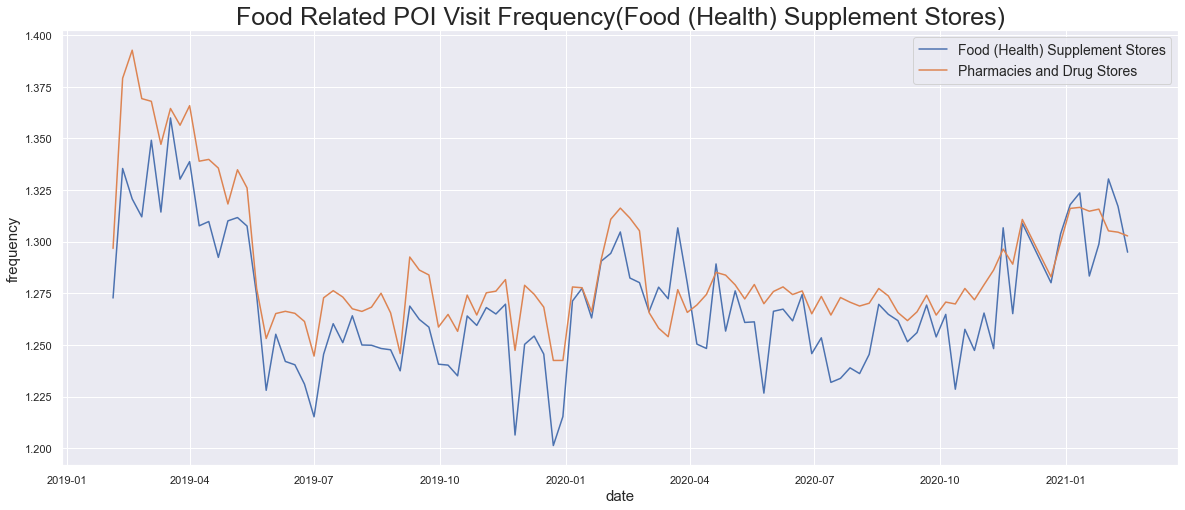

In [51]:
sns.lineplot(data= weekly_freq_ctg[weekly_freq_ctg.category=='Food (Health) Supplement Stores'],
             x="date", y="frequency", hue="sub_category").set(title="Food Related POI Visit Frequency(Food (Health) Supplement Stores)")
plt.legend(fontsize='14')
plt.show()

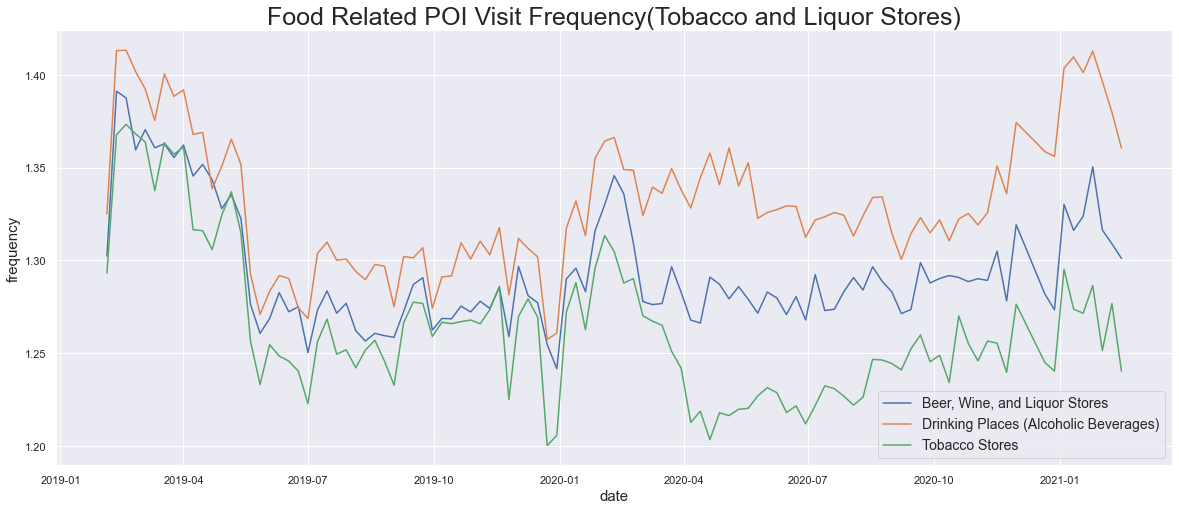

In [52]:
sns.lineplot(data= weekly_freq_ctg[weekly_freq_ctg.category=='Tobacco and Liquor Stores'],
             x="date", y="frequency", hue="sub_category").set(title="Food Related POI Visit Frequency(Tobacco and Liquor Stores)")
plt.legend(fontsize='14')
plt.show()

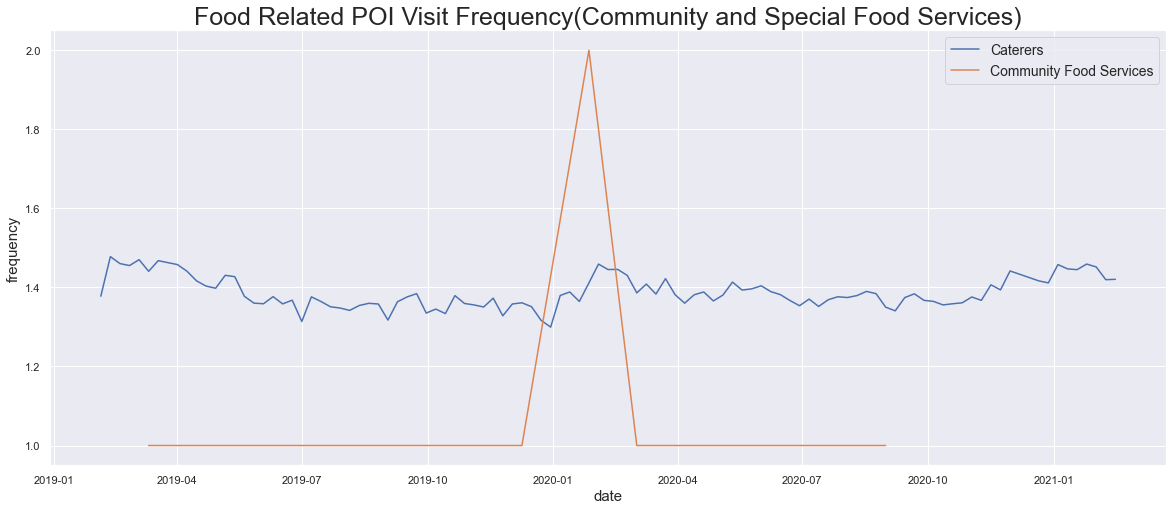

In [53]:
sns.lineplot(data= weekly_freq_ctg[weekly_freq_ctg.category=='Community and Special Food Services'],
             x="date", y="frequency", hue="sub_category").set(title="Food Related POI Visit Frequency(Community and Special Food Services)")
plt.legend(fontsize='14')
plt.show()